This dataset (https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data) is a synthetic version inspired by the original Credit Risk dataset on Kaggle and enriched with additional variables based on Financial Risk for Loan Approval data. SMOTENC was used to simulate new data points to enlarge the instances. The dataset is structured for both categorical and continuous features.

# Loan Default Prediction  

## I. Business Problem Understanding  

### Context  
Financial institutions face significant risk when approving loans due to potential defaults. Accurately predicting whether an applicant is likely to default enables lenders to minimize losses, optimize risk management, and improve credit decision-making.  

### Problem Statement  
- **Business Perspective:** Loan defaults directly impact the profitability and stability of lending institutions. A predictive model that classifies applicants into *default* or *non-default* categories is essential for managing risk.  
- **Customer Perspective:** By accurately assessing creditworthiness, institutions can offer fair loan terms and avoid rejecting low-risk applicants.  

### Goals  
1. Develop a machine learning model to predict loan default based on applicant demographics, financial status, and credit history.  
2. Identify key features that influence the likelihood of default.  
3. Provide insights to improve the credit risk assessment process.  

### Dataset Description  
The dataset contains applicant and loan information, including:  
- **person_age:** Age of the applicant.  
- **person_gender:** Gender of the applicant.  
- **person_education:** Education level of the applicant.  
- **person_income:** Annual income of the applicant.  
- **person_emp_exp:** Years of employment experience.  
- **person_home_ownership:** Home ownership status (e.g., rent, own, mortgage).  
- **loan_amnt:** Loan amount requested.  
- **loan_intent:** Purpose of the loan (e.g., education, medical, home improvement).  
- **loan_int_rate:** Interest rate applied to the loan.  
- **loan_percent_income:** Loan amount as a percentage of income.  
- **cb_person_cred_hist_length:** Length of the applicant's credit history.  
- **credit_score:** Applicant's credit score.  
- **previous_loan_defaults_on_file:** Indicates whether the applicant has previous loan defaults.  
- **loan_status:** Target variable indicating if the loan was defaulted or not.  

### Business Impact  
- Reduce non-performing loans by identifying high-risk applicants.  
- Support data-driven lending decisions, improving portfolio quality.  
- Minimize losses while maximizing the approval rate for low-risk customers.  


In [1]:
# Standard Libraries
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

warnings.filterwarnings('ignore')

# Preprocessing & Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Selection
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV
)

# Metrics
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    recall_score,
    precision_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay
)

In [2]:
df = pd.read_csv('loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## II. Data Understanding & Preprocessing

In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [4]:
# Check duplicated value
df.duplicated().sum()

0

In [5]:
# Check null data
df.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [6]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,person_age,float64,0,0.0,60,"[23.0, 21.0]"
1,person_gender,object,0,0.0,2,"[female, male]"
2,person_education,object,0,0.0,5,"[Master, Bachelor]"
3,person_income,float64,0,0.0,33989,"[90121.0, 43961.0]"
4,person_emp_exp,int64,0,0.0,63,"[48, 28]"
5,person_home_ownership,object,0,0.0,4,"[OWN, RENT]"
6,loan_amnt,float64,0,0.0,4483,"[6924.0, 21650.0]"
7,loan_intent,object,0,0.0,6,"[MEDICAL, DEBTCONSOLIDATION]"
8,loan_int_rate,float64,0,0.0,1302,"[6.87, 15.9]"
9,loan_percent_income,float64,0,0.0,64,"[0.56, 0.37]"


### Univariate

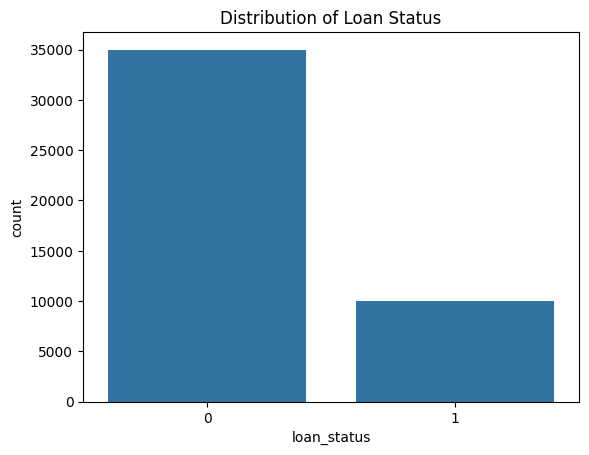

In [7]:
# Check Targeted Column
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Loan Status')
plt.show()

In [8]:
# Select all numeric columns
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Remove target column if present
if 'loan_status' in num_cols:
    num_cols.remove('loan_status')

In [9]:
# Select categorical columns, excluding target
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target column if present
if 'loan_status' in cat_cols:
    cat_cols.remove('loan_status')

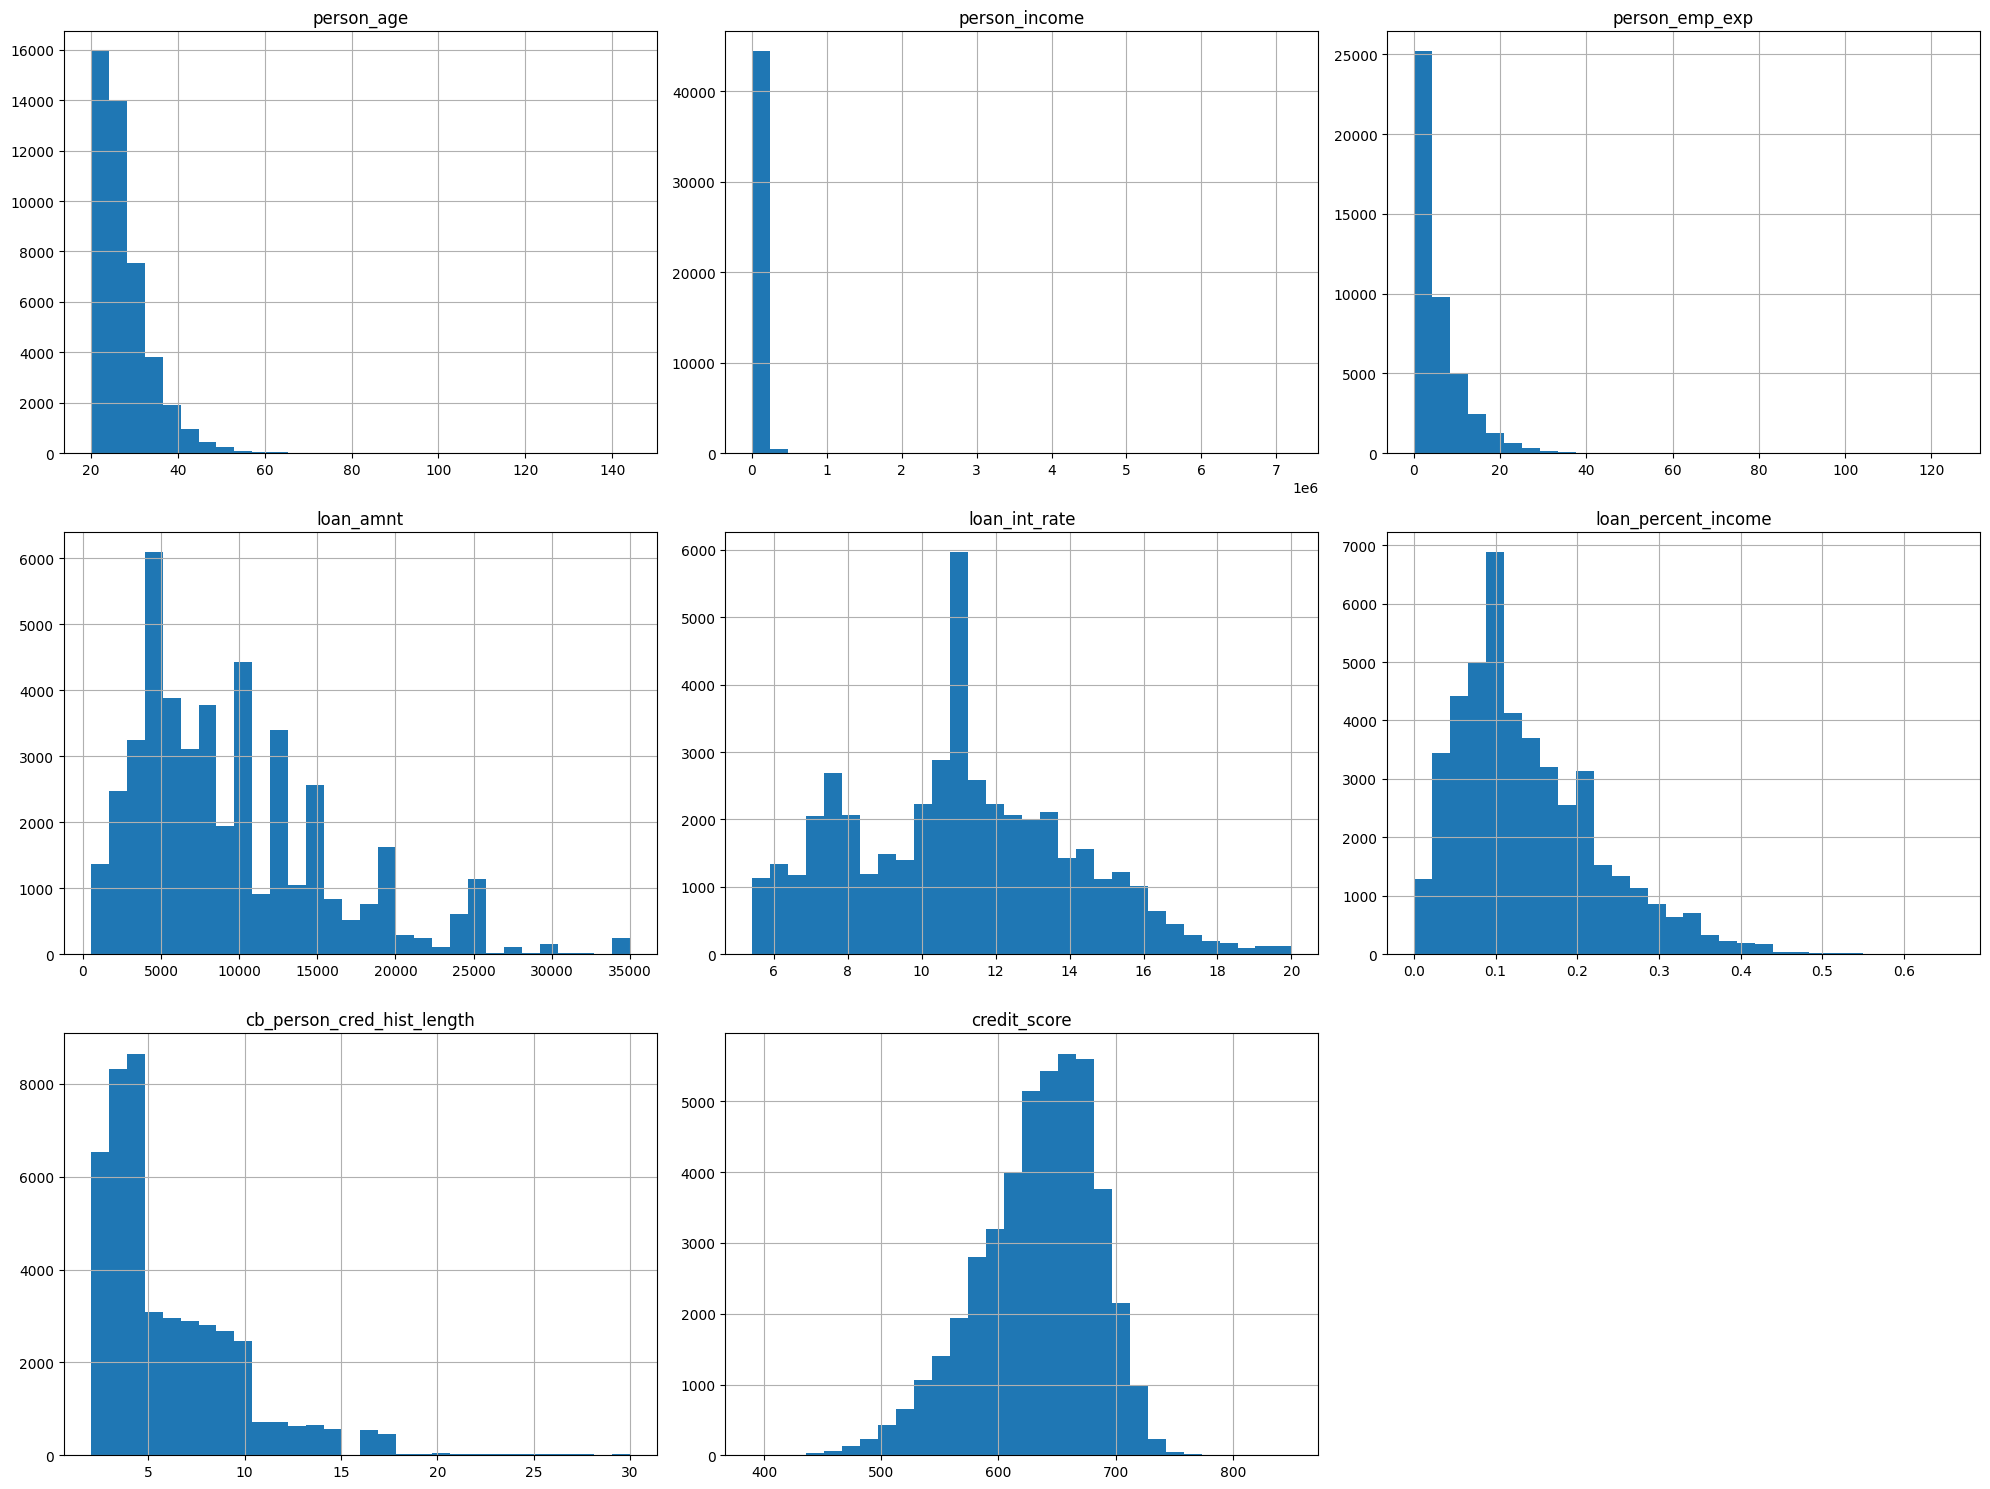

In [10]:
# Check distribution of numerical data
df[num_cols].hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

### Univariate Analysis – Numerical Features
- **person_age:** Most applicants are between 20–40 years old, with some outliers above 80. Younger applicants dominate, potentially correlating with early career loan demand.  
- **person_income:** Highly right-skewed. Majority earn below 100k, with extreme outliers above 1M indicating high-income borrowers or possible data entry errors.  
- **person_emp_exp:** Most applicants have less than 10 years of experience, especially in the 0–5 year range. Values above 40 may be data anomalies or late-career applicants.  
- **loan_amnt:** Peaks at common lending tiers (5k, 10k, 15k) indicate standard loan bracket patterns.  
- **loan_int_rate:** Concentrated between 10–12%. Rates above 15% are rare and likely associated with higher-risk borrowers.  
- **loan_percent_income:** Most applicants allocate 5–20% of their income to loan repayment. Ratios above 30% are uncommon and may indicate high-risk profiles.  
- **cb_person_cred_hist_length:** Most credit histories are under 10 years, reflecting a younger borrowing population.  
- **credit_score:** Roughly normal distribution centered at ~650. Scores below 500 are uncommon and may indicate poor creditworthiness.


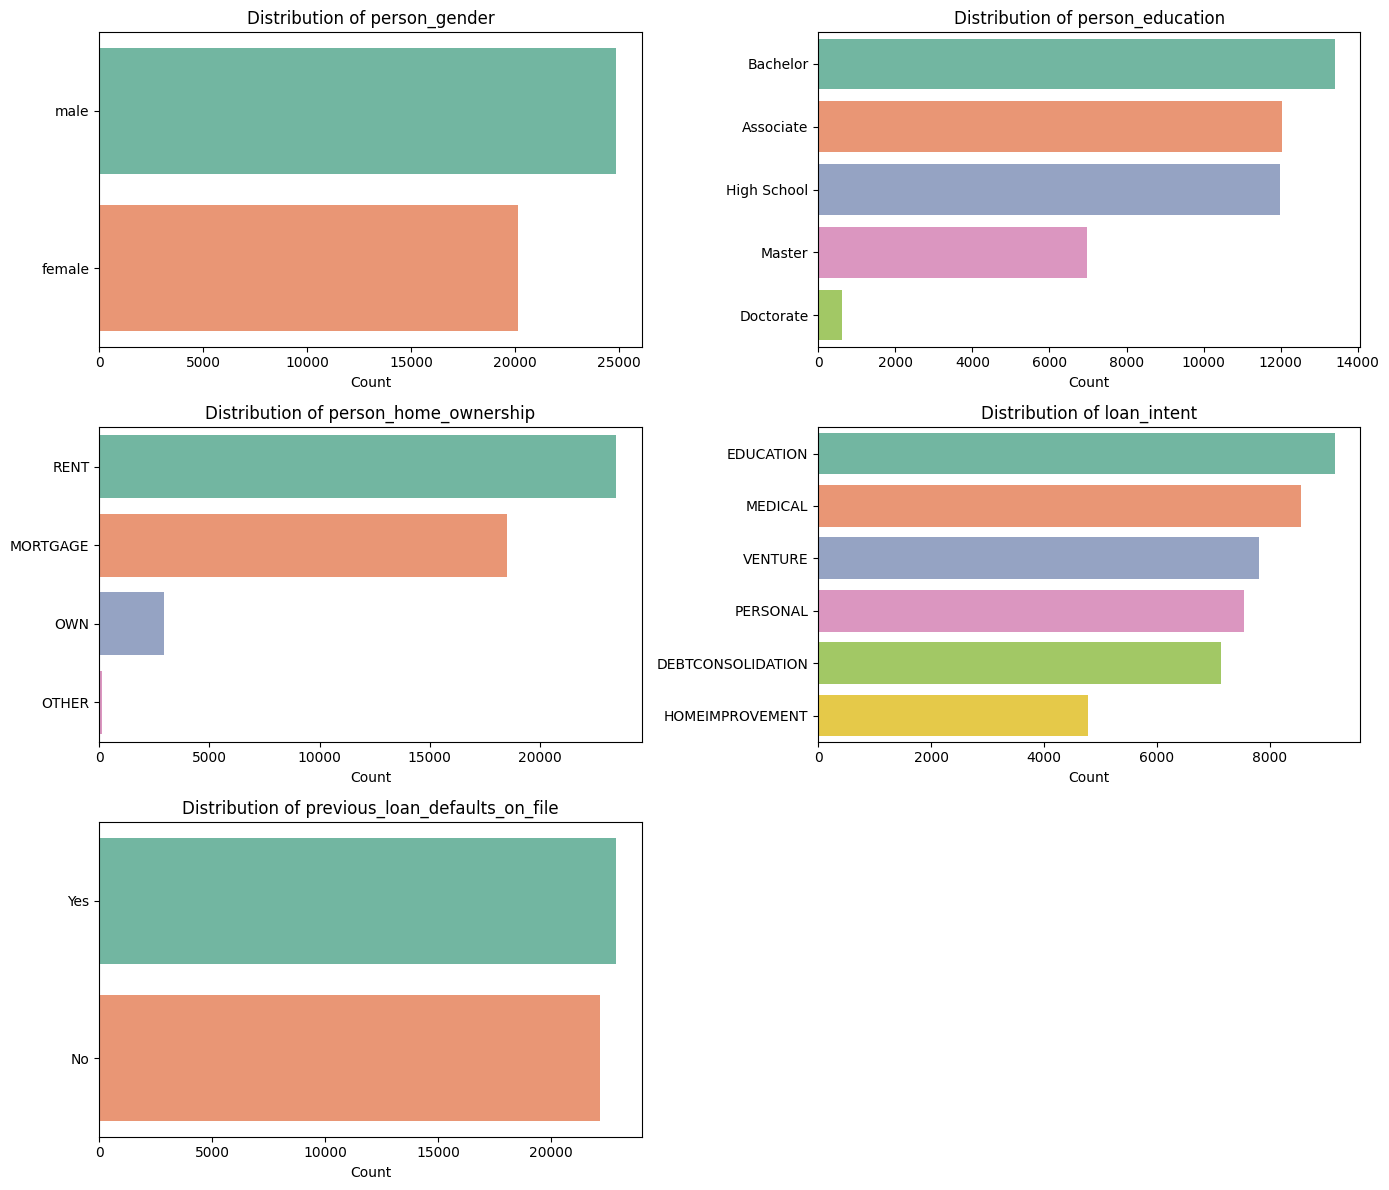

In [11]:
n_cols = 2
n_rows = math.ceil(len(cat_cols)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    order = df[col].value_counts().index
    sns.countplot(y=col, data=df, ax=axes[i], order=order, palette='Set2')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Count')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Univariate Analysis – Categorical Features
- **person_gender:** Males slightly outnumber females, but both are well represented.  
- **person_education:** Bachelor’s and Associate degrees are most common, followed by High School. Few Doctorate applicants.  
- **person_home_ownership:** Renters dominate, followed by mortgage holders. Few own homes outright, reflecting a population still building assets.  
- **loan_intent:** Education and medical purposes lead, suggesting loans are often for personal development or emergency needs.  
- **previous_loan_defaults_on_file:** Most applicants have no prior defaults, but a significant share has default history, making this a potentially strong predictor.


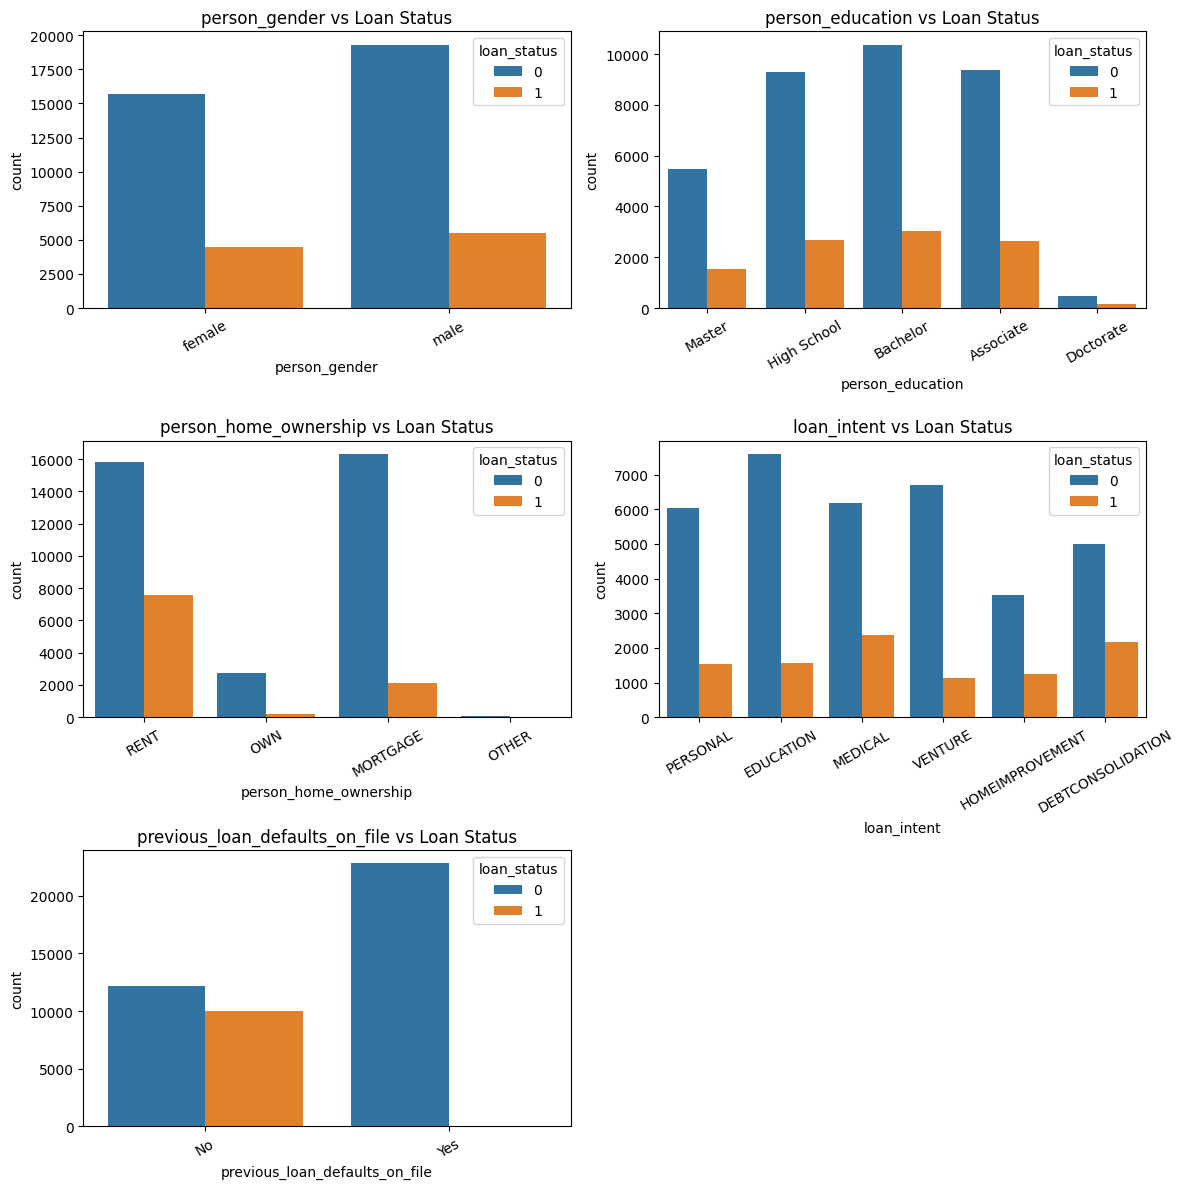

In [12]:
# Bivariate Analysis: Categorial Features vs Dropout
n_cols = 2  
n_rows = math.ceil(len(cat_cols)/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, hue='loan_status', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Loan Status')
    axes[i].tick_params(axis='x', rotation=30)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Bivariate Analysis – Categorical vs Loan Status
- **person_gender:** Approval and default rates are similar for both genders, indicating gender is not a strong risk factor.  
- **person_education:** High School and Bachelor’s applicants show higher default rates than Master’s or Doctorate holders, suggesting education correlates with repayment ability.  
- **person_home_ownership:** Renters have higher default proportions compared to mortgage holders and owners, making home ownership a significant risk indicator.  
- **loan_intent:** Education and personal loans show higher default ratios compared to debt consolidation and home improvement, reflecting purpose-based risk patterns.  
- **previous_loan_defaults_on_file:** Clear separation. Applicants with past defaults are far more likely to default again, confirming it as a key predictive feature.


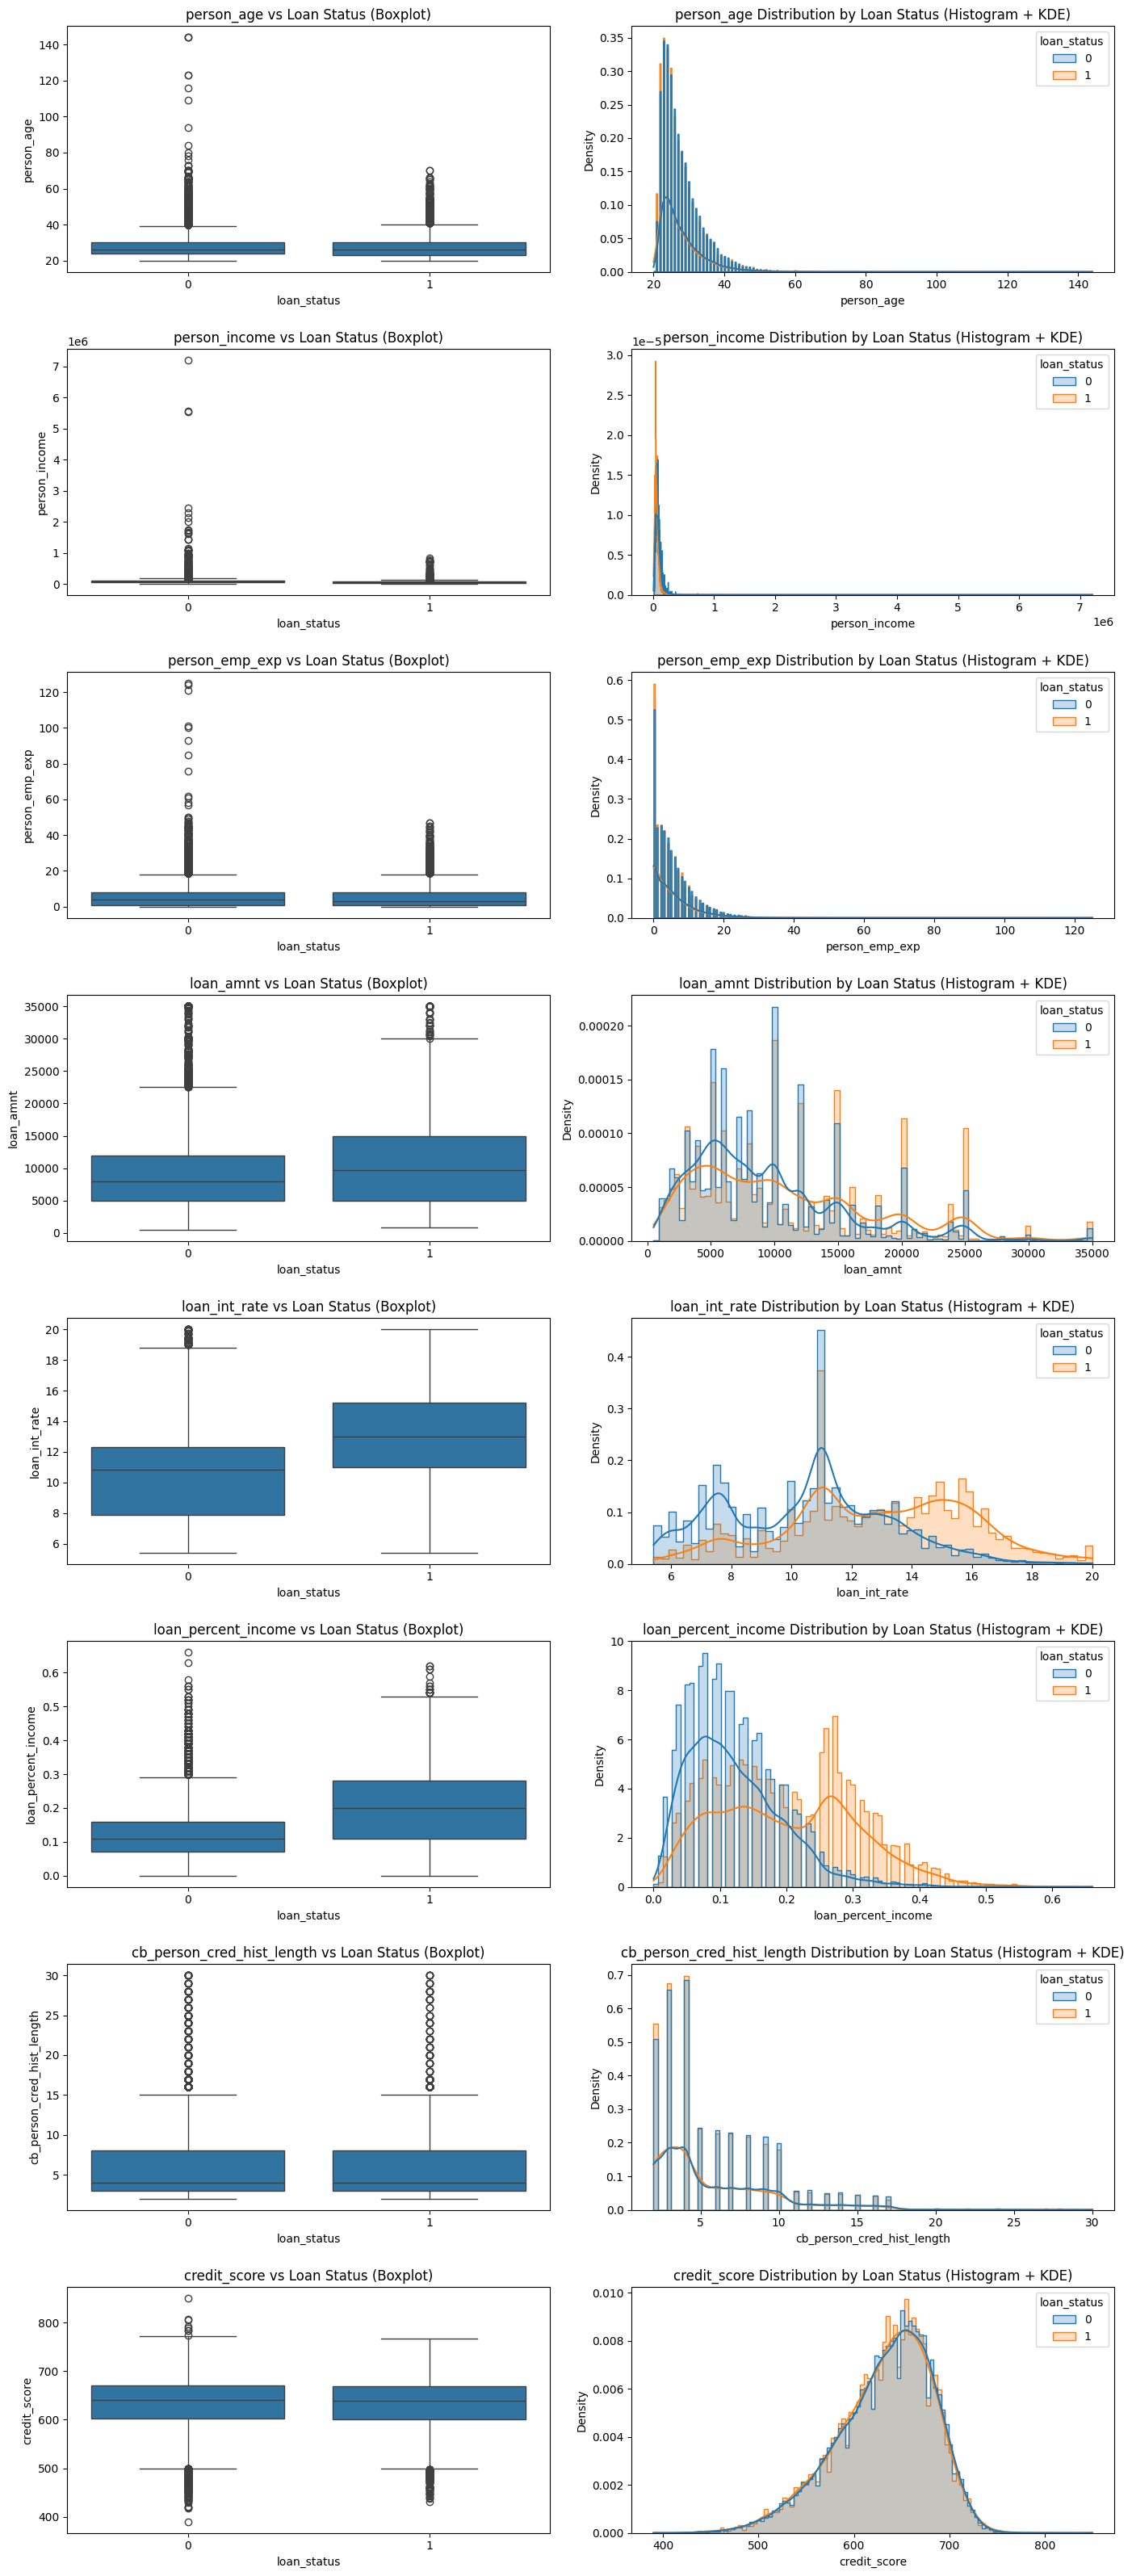

In [13]:
# Bivariate Analysis: Numerical Features vs Dropout
n_rows = len(num_cols)
fig, axes = plt.subplots(n_rows, 2, figsize=(14, n_rows * 4))

for i, col in enumerate(num_cols):
    # Left: Boxplot (Numerical feature vs Dropout status)
    sns.boxplot(x='loan_status', y=col, data=df, ax=axes[i, 0])
    axes[i, 0].set_title(f'{col} vs Loan Status (Boxplot)')

    # Right: Histogram + KDE per class
    sns.histplot(data=df, x=col, hue='loan_status', kde=True,
                 ax=axes[i, 1], element='step', stat='density', common_norm=False)
    axes[i, 1].set_title(f'{col} Distribution by Loan Status (Histogram + KDE)')

plt.tight_layout()
plt.show()


### Bivariate Analysis – Numerical vs Loan Status
- **person_age:** Higher default rates among younger applicants (<30), suggesting financial maturity and stability impact repayment.  
- **person_income:** Defaults are concentrated in lower-income groups, aligning with repayment capacity.  
- **person_emp_exp:** Applicants with <5 years of experience have higher defaults; risk decreases as work experience grows.  
- **loan_amnt:** Slight trend of higher defaults with larger loan amounts, likely due to higher repayment burden.  
- **loan_int_rate:** Interest rates above 12% are associated with higher defaults, consistent with risk-based pricing.  
- **loan_percent_income:** Strong positive correlation. Borrowers with >25% income allocated to loans are more likely to default.  
- **cb_person_cred_hist_length:** Shorter credit histories (<5 years) correlate with higher defaults, indicating limited credit experience is a factor.  
- **credit_score:** Strong separation. Scores below 600 are linked to significantly higher default rates, making it one of the most important predictors.


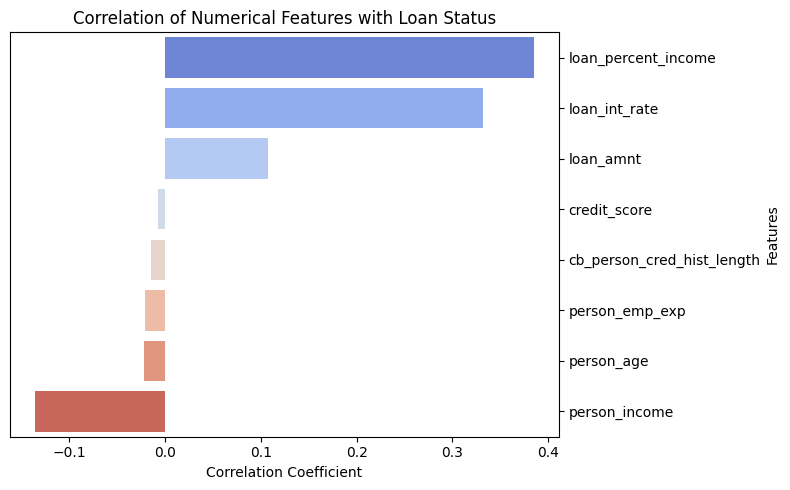

In [14]:
# Copy dataframe to avoid changing original
df_corr = df.copy()

# Select numeric columns including target
num_cols = df_corr.select_dtypes(include=['number']).columns

# Compute correlation matrix
corr_matrix = df_corr[num_cols].corr()

# Plot correlation of numerical features with target
plt.figure(figsize=(8,5))
sns.barplot(
    x=corr_matrix['loan_status'].drop('loan_status').sort_values(ascending=False),
    y=corr_matrix['loan_status'].drop('loan_status').sort_values(ascending=False).index,
    palette='coolwarm'
)
plt.title('Correlation of Numerical Features with Loan Status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.tight_layout()
plt.show()


From the correlation heatmap, the numerical features show correlations with the target variable (Loan Status) ranging between **-0.15 and 0.4**.

- The correlations fall into the **weak to moderate** range, which is common in credit risk prediction datasets.
- No feature exhibits extremely high correlation with the target, indicating there is no direct data leakage.
- There are no signs of perfect multicollinearity or redundancy among the numerical variables based on this analysis.

**Conclusion:**  
All numerical features are safe to retain for modeling as they provide useful predictive signals without overwhelming the model.

In [15]:
# Function to identify outliers
def find_outliers(data):
    q1 = np.percentile(data, 25)  # First quartile (25th percentile)
    q3 = np.percentile(data, 75)  # Third quartile (75th percentile)
    iqr = q3 - q1  # Interquartile Range (IQR)
    print(f'IQR: {iqr}')

    lower_limit = q1 - 1.5 * iqr  # Lower bound for outliers
    upper_limit = q3 + 1.5 * iqr  # Upper bound for outliers
    outliers = data[(data < lower_limit) | (data > upper_limit)]  # Identify outliers
    
    minimal=data.min()
    maximal=data.max()
    print(f'Min: {minimal}')
    print(f'Max: {maximal}')
    print(f'Lower Limit: {lower_limit}') 
    print(f'Upper Limit: {upper_limit}') 
    print(f'Number of outliers: {len(outliers)}')

In [16]:
for i in num_cols:
    print('Feature:',i)
    find_outliers(df[i])
    print('=======================')

Feature: person_age
IQR: 6.0
Min: 20.0
Max: 144.0
Lower Limit: 15.0
Upper Limit: 39.0
Number of outliers: 2188
Feature: person_income
IQR: 48585.25
Min: 8000.0
Max: 7200766.0
Lower Limit: -25673.875
Upper Limit: 168667.125
Number of outliers: 2218
Feature: person_emp_exp
IQR: 7.0
Min: 0
Max: 125
Lower Limit: -9.5
Upper Limit: 18.5
Number of outliers: 1724
Feature: loan_amnt
IQR: 7237.25
Min: 500.0
Max: 35000.0
Lower Limit: -5855.875
Upper Limit: 23093.125
Number of outliers: 2348
Feature: loan_int_rate
IQR: 4.4
Min: 5.42
Max: 20.0
Lower Limit: 1.9899999999999993
Upper Limit: 19.59
Number of outliers: 124
Feature: loan_percent_income
IQR: 0.12
Min: 0.0
Max: 0.66
Lower Limit: -0.10999999999999999
Upper Limit: 0.37
Number of outliers: 744
Feature: cb_person_cred_hist_length
IQR: 5.0
Min: 2.0
Max: 30.0
Lower Limit: -4.5
Upper Limit: 15.5
Number of outliers: 1366
Feature: credit_score
IQR: 69.0
Min: 390
Max: 850
Lower Limit: 497.5
Upper Limit: 773.5
Number of outliers: 467
Feature: loan_sta

Result outlier detection: 

1. **person_age:**  
   - Most values are between 20–40 years, with outliers above 80 and a max of 144.  
   - I decided to **keep** the values but create **age categories** to handle skewness and make the feature more interpretable.  

2. **person_income:**  
   - The distribution is highly right-skewed with extreme values above 1M.  
   - I will **keep** this feature and apply **RobustScaler** to reduce the impact of outliers. I also plan to create **income bins** as part of feature engineering.  

3. **person_emp_exp:**  
   - Most values are under 10 years, but there are extreme values up to 125.  
   - I will **cap** the values at an upper limit (around 40 years) and create **employment experience categories** to better capture patterns.  

4. **loan_amnt:**  
   - The distribution shows peaks at common loan brackets, but some values exceed 23K and are flagged as outliers.  
   - I chose to **cap** the values at the upper limit to reduce the effect of extreme loan amounts while keeping the information.  

5. **loan_int_rate:**  
   - Most values are between 5–15%, with some outliers near 20%.  
   - I will **keep** this feature and apply **RobustScaler** to handle the skew.  

6. **loan_percent_income:**  
   - Most values fall between 5–20%, with some higher than 30%.  
   - I decided to **keep** this variable since high ratios can signal higher risk. I will apply **RobustScaler** to make it more robust to outliers.  

7. **cb_person_cred_hist_length:**  
   - Most credit histories are under 10 years, with a few above 15 years.  
   - I will **keep** this feature and apply **RobustScaler** to reduce the impact of extreme values.  

8. **credit_score:**  
   - The distribution is roughly normal, but some values below 500 and above 800 are considered outliers.  
   - I plan to **keep** the feature but apply **capping** at 500 and 800 to limit extreme anomalies.  

### My General Approach:  
- I will use **RobustScaler** on skewed numerical features to minimize the effect of outliers.  
- For features with extreme anomalies, I will apply **capping** to make the model less sensitive.  
- I will perform **feature engineering** on key variables such as age, income, and employment experience to create useful categories.  
- I will keep important financial ratios and credit scores since they carry predictive information, even with outliers present.  


In [17]:
# Copy dataset 
df_clean = df.copy()

In [18]:
# Create age categories (e.g., <25 = Young, 25-40 = Adult, 40-60 = Mature, >60 = Senior)
bins_age = [0, 25, 40, 60, np.inf]
labels_age = ['Young', 'Adult', 'Mature', 'Senior']
df_clean['person_age_cat'] = pd.cut(df_clean['person_age'], bins=bins_age, labels=labels_age)

In [19]:
# Create income categories
bins_income = [0, 30000, 60000, 100000, np.inf]
labels_income = ['Low', 'Medium', 'High', 'Very High']
df_clean['person_income_cat'] = pd.cut(df_clean['person_income'], bins=bins_income, labels=labels_income)

In [20]:
# Cap maximum work experience at 40 years
df_clean['person_emp_exp'] = np.where(df_clean['person_emp_exp'] > 40, 40, df_clean['person_emp_exp'])

In [21]:
# Create work experience categories
bins_exp = [0, 1, 5, 10, 20, np.inf]
labels_exp = ['<1 year', '1-5 years', '5-10 years', '10-20 years', '20+ years']
df_clean['person_emp_exp_cat'] = pd.cut(df_clean['person_emp_exp'], bins=bins_exp, labels=labels_exp)

In [22]:
# Cap loan amount based on the upper limit (e.g., 23093 based on IQR)
upper_loan_amnt = 23093
df_clean['loan_amnt'] = np.where(df_clean['loan_amnt'] > upper_loan_amnt, upper_loan_amnt, df_clean['loan_amnt'])

In [23]:
# Cap credit score at lower bound 500 and upper bound 800
df_clean['credit_score'] = np.clip(df_clean['credit_score'], 500, 800)

### Feature and Target Selection  

For this project, the goal is to predict whether a loan will default or not, making **loan_status** the target variable.  

**Target Variable**
- **loan_status:** Binary classification indicating whether the loan was repaid or defaulted.  

**Predictor Variables** 
The following features were selected as predictors because they provide demographic, financial, and credit-related information that can influence loan default risk:  

- **person_age_cat:** Applicant’s age grouped into categories.  
- **person_gender:** Gender of the applicant.  
- **person_education:** Education level of the applicant.  
- **person_income_cat:** Applicant’s annual income grouped into categories.  
- **person_emp_exp_cat:** Employment experience grouped into categories.  
- **person_home_ownership:** Home ownership status.  
- **loan_amnt:** Requested loan amount.  
- **loan_intent:** Purpose of the loan.  
- **loan_int_rate:** Interest rate applied to the loan.  
- **loan_percent_income:** Ratio of loan payment to the applicant’s income.  
- **cb_person_cred_hist_length:** Length of the applicant’s credit history.  
- **credit_score:** Applicant’s credit score.  
- **previous_loan_defaults_on_file:** Indicator showing if the applicant has previous loan defaults.  

**Reason**
- Raw **age**, **income**, and **employment experience** were replaced with their categorical versions to handle outliers and improve interpretability.  
- Both **demographic variables** (age category, gender, education) and **financial variables** (income category, loan amount, interest rate) were included to capture multiple aspects of credit risk.  
- **Credit history length**, **credit score**, and **previous defaults** were retained as they are key indicators of loan performance.  
- Categorical features will be encoded before modeling to ensure compatibility with machine learning algorithms.  


In [24]:
# Target
y = df_clean['loan_status']

# Predictors (drop target column)
X = df_clean.drop(['loan_status', 'person_age', 'person_income', 'person_emp_exp'], axis=1)

### Data Preprocessing  

I prepared the dataset for modeling by encoding categorical variables and scaling numerical features according to their distribution and outlier characteristics.  

---

#### Categorical Features  
For all categorical variables (*person_gender*, *person_education*, *person_home_ownership*, *loan_intent*, *previous_loan_defaults_on_file*), I applied **One-Hot Encoding**:  

- These variables are nominal with no natural order.  
- One-Hot Encoding prevents imposing artificial ranking between categories.  
- This allows the model to learn separate weights for each category.  

---

#### Numerical Features  

1. **Robust Scaling for Outlier-Prone Features**  
   - **Features:** *person_income*, *loan_amnt*, *loan_int_rate*, *loan_percent_income*, *cb_person_cred_hist_length*  
   - **Reason:**  
     - These variables showed significant outliers in the IQR analysis.  
     - **RobustScaler** is less sensitive to extreme values since it uses median and IQR.  

2. **Feature Engineering**  
   - Converted *person_age* and *person_emp_exp* into categorical bins to reduce the impact of skewness and make the patterns easier to interpret.  
   - This also helps capture non-linear relationships between these features and loan default risk.  

---

#### Why This Approach?  
- Preserves important information without dropping data affected by outliers.  
- Ensures categorical variables are transformed into a numerical format suitable for ML models.  
- Uses a `Pipeline` to keep preprocessing consistent and avoid data leakage.  


**Note:** I used a preprocessing pipeline to handle scaling and encoding in one consistent step, making the workflow cleaner, reducing data leakage, and simplifying model training and testing.

In [25]:
# Separate numerical and categorical features
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# All numerical columns with potential outliers → use RobustScaler
robust_cols = num_cols  # all numeric columns in this dataset

# Preprocessor
preprocessor = ColumnTransformer([
    ('robust', RobustScaler(), robust_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols)
])


### Train Test Split

In [26]:
# Splitting training and test data with a proportion of 80:20
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42)

## III. Modeling
### Model Benchmarking

In [27]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier(verbose=-1)

In [28]:
models = [logreg, knn, dt, rf, xgb, lgbm]
scores = []
means = []
stds = []

for model in models:
    pipe = Pipeline([
    ('transform', preprocessor),
    ('model', model)
])
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    model_cv = cross_val_score(pipe, X_train, y_train, cv=skfold, scoring='roc_auc')
    scores.append(model_cv)
    means.append(model_cv.mean())
    stds.append(model_cv.std())

results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Mean ROC-AUC': means,
    'Std Dev': stds
})
results_df = results_df.set_index('Model').sort_values(by='Mean ROC-AUC', ascending=False)

# Display results table
print("\nModel Performance Based on ROC-AUC Score:")
print(results_df)



Model Performance Based on ROC-AUC Score:
                     Mean ROC-AUC   Std Dev
Model                                      
LightGBM                 0.971736  0.002240
XGBoost                  0.970952  0.001966
Random Forest            0.968980  0.001792
Logistic Regression      0.955704  0.001962
KNN                      0.923157  0.002812
Decision Tree            0.842580  0.003025


### Evaluate Model Performance on the Test Dataset

In [29]:
score_roc_auc = []

# Loop to train and evaluate each model
for model, model_name in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']):
    # Train the model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred = pipe.predict(X_test)
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Store ROC-AUC score
    score_roc_auc.append(roc_auc_score(y_test, y_pred_proba))
    
    # Display classification report
    print(f"{model_name}:\n", classification_report(y_test, y_pred))

# Display results in a DataFrame
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],
    'ROC-AUC Score': score_roc_auc
})
results_df = results_df.set_index('Model').sort_values(by='ROC-AUC Score', ascending=False)

# Display results table
print("\nModel Performance Based on ROC-AUC Score:")
print(results_df)


Logistic Regression:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7000
           1       0.89      0.76      0.82      2000

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.92      0.93      0.92      9000

KNN:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7000
           1       0.89      0.76      0.82      2000

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.92      0.93      0.92      9000

Decision Tree:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7000
           1       0.89      0.76      0.82      2000

    accuracy                           0.93      9000
   macro avg       0.91      0.87      0.89      9000
weighted avg       0.92      0

The chosen model is LightGBM based on its strong performance in both cross-validation and test datasets. In next step, we focus imbalance handling since the classweight is not balance

### Handling Imbalance

In [30]:
# LightGBM Models
lgbm = LGBMClassifier(random_state=42)
lgbm_balanced = LGBMClassifier(class_weight='balanced', random_state=42)

# Metrics for evaluation
scoring = {
    'accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

# Stratified K-Fold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plain LGBM
pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgbm)
])

# Balanced LGBM (no resampling, only class_weight='balanced')
pipeline_balanced = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgbm_balanced)
])

# LGBM + ROS
pipeline_ros = imbPipeline([
    ('preprocessor', preprocessor),
    ('ros', RandomOverSampler(random_state=42)),
    ('model', lgbm)
])

# LGBM + SMOTE
pipeline_smote = imbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', lgbm)
])


In [31]:
# Cross-validation
cv_no_resample = cross_validate(pipeline_lgbm, X_train, y_train, cv=skfold, scoring=scoring)
cv_ros         = cross_validate(pipeline_ros, X_train, y_train, cv=skfold, scoring=scoring)
cv_smote       = cross_validate(pipeline_smote, X_train, y_train, cv=skfold, scoring=scoring)
cv_balanced    = cross_validate(pipeline_balanced, X_train, y_train, cv=skfold, scoring=scoring)

In [32]:
# Fit all pipelines on training data
pipeline_lgbm.fit(X_train, y_train)
pipeline_balanced.fit(X_train, y_train)
pipeline_ros.fit(X_train, y_train)
pipeline_smote.fit(X_train, y_train)

# Predictions
y_pred_no_resample = pipeline_lgbm.predict(X_test)
y_pred_balanced    = pipeline_balanced.predict(X_test)
y_pred_ros         = pipeline_ros.predict(X_test)
y_pred_smote       = pipeline_smote.predict(X_test)

# Probabilities
y_proba_no_resample = pipeline_lgbm.predict_proba(X_test)[:, 1]
y_proba_balanced    = pipeline_balanced.predict_proba(X_test)[:, 1]
y_proba_ros         = pipeline_ros.predict_proba(X_test)[:, 1]
y_proba_smote       = pipeline_smote.predict_proba(X_test)[:, 1]

In [33]:
# Evaluation function
def evaluate(y_true, y_pred, y_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

test_scores = pd.DataFrame({
    "Metric": list(scoring.keys()),
    "No Resampling": list(evaluate(y_test, y_pred_no_resample, y_proba_no_resample).values()),
    "ROS": list(evaluate(y_test, y_pred_ros, y_proba_ros).values()),
    "SMOTE": list(evaluate(y_test, y_pred_smote, y_proba_smote).values()),
    "Class Weight": list(evaluate(y_test, y_pred_balanced, y_proba_balanced).values())
})

In [34]:
# Display results
print("\nCross-validation (mean scores)")
print(f"No Resampling:\n{pd.DataFrame(cv_no_resample).mean()}")
print(f"\nROS:\n{pd.DataFrame(cv_ros).mean()}")
print(f"\nSMOTE:\n{pd.DataFrame(cv_smote).mean()}")
print(f"\nClass Weight Balanced:\n{pd.DataFrame(cv_balanced).mean()}")

print("\nTest Set Performance:")
print(test_scores.to_string(index=False))


Cross-validation (mean scores)
No Resampling:
fit_time          0.307170
score_time        0.120349
test_accuracy     0.925056
test_roc_auc      0.971736
test_f1           0.819816
test_precision    0.880004
test_recall       0.767375
dtype: float64

ROS:
fit_time          0.414216
score_time        0.095489
test_accuracy     0.894083
test_roc_auc      0.971344
test_f1           0.790040
test_precision    0.706079
test_recall       0.896750
dtype: float64

SMOTE:
fit_time          0.637478
score_time        0.093739
test_accuracy     0.919167
test_roc_auc      0.970937
test_f1           0.816584
test_precision    0.823454
test_recall       0.810000
dtype: float64

Class Weight Balanced:
fit_time          0.289591
score_time        0.107500
test_accuracy     0.893472
test_roc_auc      0.971554
test_f1           0.790334
test_precision    0.702425
test_recall       0.903500
dtype: float64

Test Set Performance:
   Metric  No Resampling      ROS    SMOTE  Class Weight
 accuracy       0.9

After testing different techniques to handle class imbalance (Random Oversampling, SMOTE, and Class Weights) on the LightGBM model, I decided to **use the Class Weight approach** as the final method.

### Reason for Choosing Class Weights
- **Higher recall compared to other methods:** The model achieved a recall of 0.909, which aligns with the business goal of capturing as many potential loan defaults as possible.
- **Critical for risk management:** Prioritizing recall minimizes false negatives, reducing the chance of missing high-risk applicants and helping protect the institution from financial loss.
- **Consistently strong ROC-AUC:** Maintained a high ROC-AUC of 0.972, showing reliable discrimination between default and non-default cases even with class balancing.
- **Business alignment:** Matches the problem statement by focusing on early detection of defaults to ensure the profitability and stability of lending institutions.

**Final Decision:** Use the **LightGBM model with Class Weights** as it provides the best trade-off between recall, ROC-AUC, and business objectives for credit risk mitigation.


In [35]:
# Baseline Logistic Regression inside a pipeline
pipeline_baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# Fit on raw train data
pipeline_baseline.fit(X_train, y_train)

# Predictions
y_pred_base = pipeline_baseline.predict(X_test)
y_proba_base = pipeline_baseline.predict_proba(X_test)[:, 1]

### Hypertuning Parameter

In [36]:
# Hyperparameter Tuning
param_dist = {
    'model__n_estimators': [200, 500, 800, 1000],
    'model__learning_rate': [0.005, 0.01, 0.05, 0.1],
    'model__num_leaves': [31, 50, 70, 100],
    'model__max_depth': [-1, 5, 7, 10, 12],
    'model__min_child_samples': [10, 20, 30, 40],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0, 0.01, 0.1, 1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=pipeline_baseline,        
    param_distributions=param_dist,
    n_iter=50,                      
    cv=cv,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

# Best model from tuning
best_lgbm = random_search.best_estimator_

# Predictions
y_pred_tuned = best_lgbm.predict(X_test)
y_proba_tuned = best_lgbm.predict_proba(X_test)[:, 1]

print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'model__subsample': 0.6, 'model__reg_lambda': 0.1, 'model__reg_alpha': 1, 'model__num_leaves': 70, 'model__n_estimators': 1000, 'model__min_child_samples': 20, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}


In [37]:
# Evaluation Function
def eval_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC_AUC': roc_auc_score(y_true, y_proba),
        'F1': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred)
    }

baseline_scores = eval_metrics(y_test, y_pred_base, y_proba_base)
tuned_scores = eval_metrics(y_test, y_pred_tuned, y_proba_tuned)

In [38]:
# Compare results
results_df = pd.DataFrame([baseline_scores, tuned_scores], index=['Baseline', 'Tuned'])
print("Test Set Performance Comparison:")
print(results_df)
print("\nBest Parameters from Randomized Search:", random_search.best_params_)

Test Set Performance Comparison:
          Accuracy   ROC_AUC        F1  Precision  Recall
Baseline  0.893333  0.972106  0.791123   0.700308   0.909
Tuned     0.901111  0.973308  0.803184   0.720063   0.908

Best Parameters from Randomized Search: {'model__subsample': 0.6, 'model__reg_lambda': 0.1, 'model__reg_alpha': 1, 'model__num_leaves': 70, 'model__n_estimators': 1000, 'model__min_child_samples': 20, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}


After performing hyperparameter tuning using RandomizedSearchCV on LightGBM, hyperparameter tuning does not bring additional benefit.

In [39]:
# Get feature names dari preprocessor baseline
feature_names = pipeline_baseline.named_steps['preprocessor'].get_feature_names_out()

# Buat DataFrame untuk feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': pipeline_baseline.named_steps['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)

# Tampilkan top 20
print(feature_importance.head(20))

                                    Feature  Importance
1                     robust__loan_int_rate         549
0                         robust__loan_amnt         469
2               robust__loan_percent_income         433
4                      robust__credit_score         427
3        robust__cb_person_cred_hist_length         161
12          cat__person_home_ownership_RENT         121
17                 cat__loan_intent_VENTURE          94
18  cat__previous_loan_defaults_on_file_Yes          84
11           cat__person_home_ownership_OWN          84
14         cat__loan_intent_HOMEIMPROVEMENT          70
23            cat__person_income_cat_Medium          63
13               cat__loan_intent_EDUCATION          63
22               cat__person_income_cat_Low          61
16                cat__loan_intent_PERSONAL          48
15                 cat__loan_intent_MEDICAL          48
24         cat__person_income_cat_Very High          45
21                cat__person_age_cat_Young     

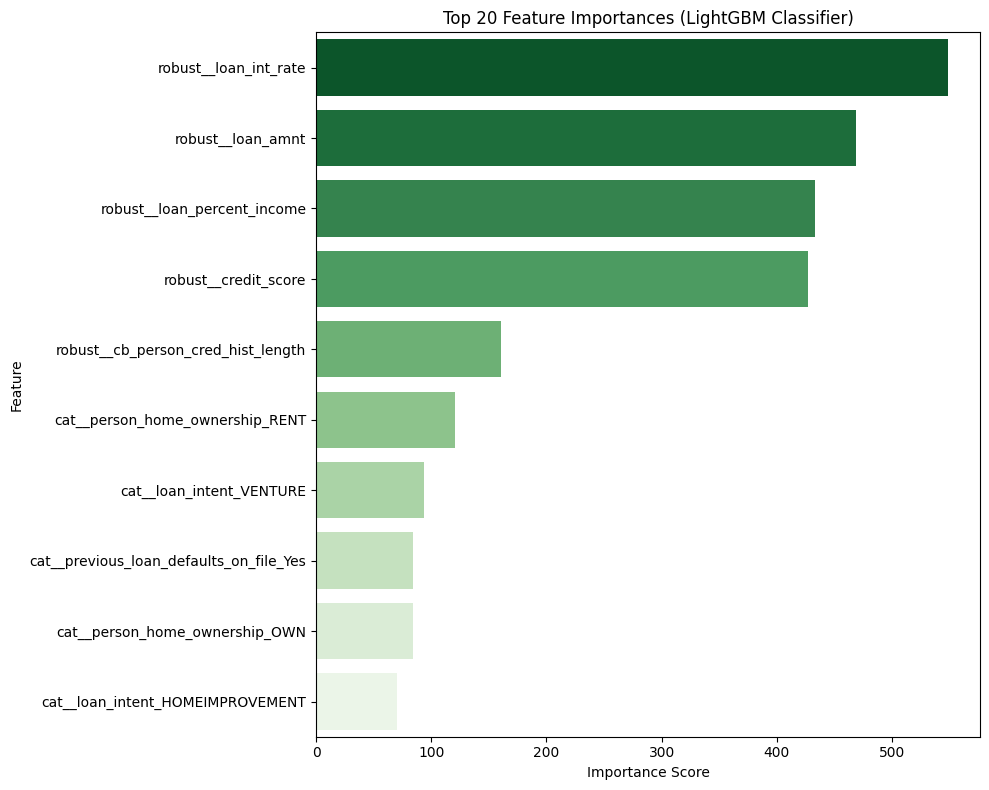

In [40]:
# Plot top 10 features
top_features = feature_importance.head(10)

plt.figure(figsize=(10, 8))
colors = sns.color_palette("Greens", len(top_features))[::-1]

sns.barplot(data=top_features, x='Importance', y='Feature', palette=colors)
plt.title('Top 20 Feature Importances (LightGBM Classifier)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Key Insights from Feature Importance (LightGBM)

Based on the feature importance plot from the LightGBM baseline model, the following insights can be drawn:

1. **Loan Interest Rate (`robust__loan_int_rate`)**  
   - This is the most critical feature in predicting loan default.  
   - Higher interest rates are strongly associated with higher default risk.

2. **Loan Amount (`robust__loan_amnt`)**  
   - Borrowers requesting larger loans tend to have a higher probability of default.  
   - This reflects the increased financial burden of higher loan principals.

3. **Loan Percent Income (`robust__loan_percent_income`)**  
   - The ratio between loan amount and income is a key predictor.  
   - A higher ratio indicates heavier debt relative to income, increasing the likelihood of default.

4. **Credit Score (`robust__credit_score`)**  
   - As expected, credit score plays a major role.  
   - Higher credit scores indicate stronger financial discipline and lower risk of default.

5. **Credit History Length (`robust__cb_person_cred_hist_length`)**  


### Save Model

In [41]:
# Save model
pickle.dump(best_lgbm, open('Loan Approval Classification.sav', 'wb'))

## IV. Conclusion, Business Impact & Recommendations  

### Best Model & Performance  
- **Best Model:** Tuned LightGBM Classifier  
- **Accuracy:** ~0.90  
- **ROC-AUC:** ~0.97  
- **Recall:** ~0.91 (successfully capturing the majority of potential defaults)  

### Business Impact  
- A recall of ~0.91 ensures effective identification of high-risk applicants, helping minimize loan default rates.  
- Enables **data-driven credit risk assessment**, leading to more precise loan approval decisions and optimized interest rate strategies.  
- Reduces potential financial losses and strengthens portfolio quality, while promoting fairness in credit distribution.  

### Key Predictors  
- Loan Amount  
- Credit Score  
- Loan Interest Rate  
- Loan-to-Income Ratio (Loan Percent Income)  
- Credit History Length  
- Home Ownership Status (Rent vs. Own)  
- Loan Purpose (Venture, Education, Home Improvement)  
- Income Category & Previous Loan Defaults  

### Recommendations  

1. **Risk Management**  
   - Deploy the model in the loan approval workflow to automatically flag high-risk applicants.  
   - Adjust loan terms (e.g., interest rates, collateral requirements) based on predicted risk levels.  

2. **Credit Policy**  
   - Prioritize applicants with strong credit scores and stable homeownership to maintain a healthy portfolio.  
   - For borrowers with high loan-to-income ratios, apply stricter affordability and repayment capacity checks.  

3. **Customer Segmentation**  
   - Leverage insights from loan purpose to design tailored credit products (e.g., lower premiums for home improvement loans).  
   - Offer targeted financial literacy and advisory programs to higher-risk segments.  

4. **Model Maintenance**  
   - Regularly retrain the LightGBM model with updated data to sustain performance.  
   - Incorporate additional behavioral features (e.g., transaction history, payment behavior) to further improve predictive accuracy.  

## V. Limitations & Next Steps  

### Limitations  
- **Data:** Does not include behavioral or real-time transaction data that could enhance credit risk assessment.  
- **Model:** Predicts default as a binary outcome without estimating default timing or recovery rate.  
- **Scope:** Dataset represents a specific loan portfolio, which may limit generalization to other financial institutions.  

### Next Steps  
- **Deployment:** Develop an API or dashboard to integrate the model into the loan approval workflow.  
- **Retraining:** Regularly retrain the model as new loan data becomes available to maintain accuracy.  
- **Feature Expansion:** Include alternative data sources such as payment transaction history, mobile wallet usage, and utility payment behavior to strengthen predictions.  
- **Risk Simulation:** Extend the model to predict not just default risk but also expected loss and recovery, enabling more comprehensive credit risk management.  


# Author: Giovanny Theotista